In [91]:
import pandas as pd
import ast

df = pd.read_csv('../exports/export_2024-04-07.csv', header=None, names=['ID', 'Title', 'Date', 'Keywords'])

df.drop(df.index[0], inplace=True) # csv header row

def safe_literal_eval(s):
  try:
    return ast.literal_eval(s)
  except ValueError:
    return []
  except SyntaxError:
    return []

# converts the string representation of the list to a list
df['Keywords'] = df['Keywords'].apply(safe_literal_eval)

# convert the date to a datetime object for easier manipulation
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

all_dates_by_week = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='W')

In [89]:

# format the date ranges for visualization
date_ranges = list(zip(all_dates_by_week[:-1], all_dates_by_week[1:] - pd.Timedelta(1))) 
date_ranges_named = [f"{start.date()} - {end.date()}" for start, end in date_ranges]  

# create a dataframe to store the weekly article count
weekly_df = pd.DataFrame(date_ranges_named, columns=['Week'])
weekly_df[['Start', 'End']] = [(start, end) for start, end in date_ranges]

# sum up the articles for each week
for start, end in date_ranges:
  mask = (df['Date'] >= start) & (df['Date'] < end)
  weekly_df.loc[weekly_df['Start'] == start, 'Article count'] = mask.sum()

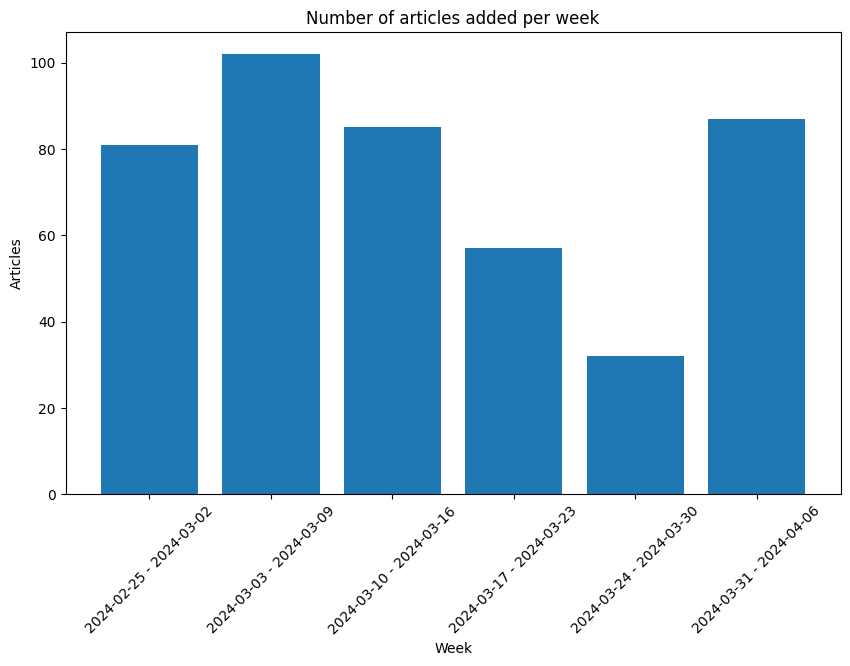

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(weekly_df['Week'], weekly_df['Article count'])
plt.xlabel('Week')
plt.ylabel('Articles')
plt.title('Number of articles added per week')
plt.xticks(rotation=45)
plt.show()
